In [103]:
!pip install monai
!pip install natsort

# Introduction
* Brain tumor Semantic segmentation에 대해서 알아보도록 하겠습니다. 
* Brain tumor에서는 많은 데이터가 있는데요 그중에서 Challenge data로 잘 알려진 Brats 2020년으로 하도록 하겠습니다. 
* Brats 는 꾸준히 Tumor dataset으로 제공되어지며 2023까지 꾸준히 나오고 있습니다.
* 아래의 그림과 같이 데이터의 경우 Multi-Modal의 문제로 Brain의 여러 domain을 한번에 활용하여 접근을 합니다. 
* 총 4개의 modal 있음 
  * T2 and FLAIR의 경우 tissue water relaxational properties(조직 수분)을 보기에 용이함. (영역이 넓음) 
  * T1의 경우 병변의 대한 위치를 나타내며 각기 다른 특징들을 뽑을수 있다.
  * T1Gd 조영제를 투과하여 T1의 영상의 contrast를 올린 영상 , 혈관이 잘 보이는 특징을 가지고 있음.

https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation

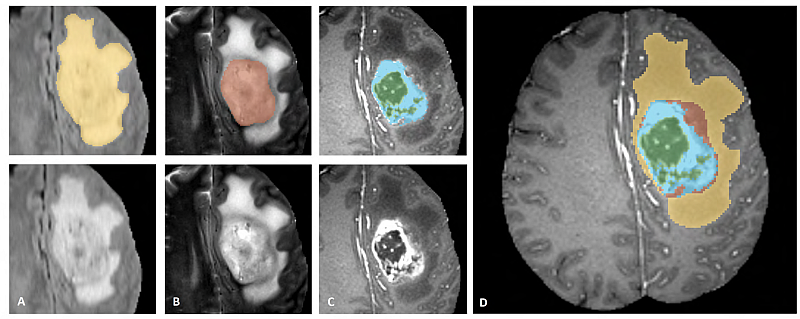

## Why need image processing?
* Brain Tumor중에서 Gliomas라는 종류로서 33%의 비중을 차지합니다.
* 이러한 환자의 진단은 여전히 어렵고 발병시 2년 이하의 생존률을 가지는 위험한 병입니다.
* 하지만 이러한 병변을 판단하는건 가장큰 지름 + 정성적인 평가로만 가능하다 -> 그렇다면 Image processing의역할이 필요함. 
* 결국 이러한 방법들은 자동적으로 tumor의 영역을 측정하는데 필요합니다. 
* MICCAI 2020년에 solution을 기반한 논문도 출간 되었습니다. 

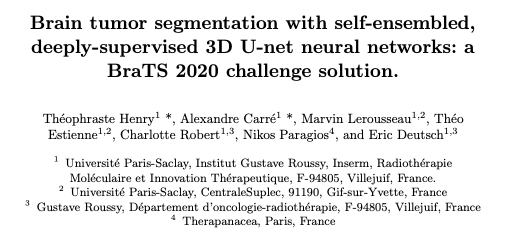

## How get annotation? 
* 정확한 annotation을 얻기 위해서는 다양한 modal에서 영상의 annotation이 필요합니다. 
* 총 3개의 class가 있음. 
  * enhancing tumor (ET) : Tumor가 종양으로 커지고 있는 영역 (T1Gd에서 잘보임)
  * non enhancing tumor (NET) & necrotic tumor (NCR) : 종양부분 커지지 않는 영역 (T1Gd & T1에서 잘보임) 
  * peritumoral edema (ED): 종양 주위에 발생하는 부종 (FLAIR)에서 잘보임
  * ET/NET/NCR영역을 합하여 tumor core를 만들어냄.
  * 마지막으로 ED를 붙이면 전체 tumor가 완성이 되어짐.
  
  
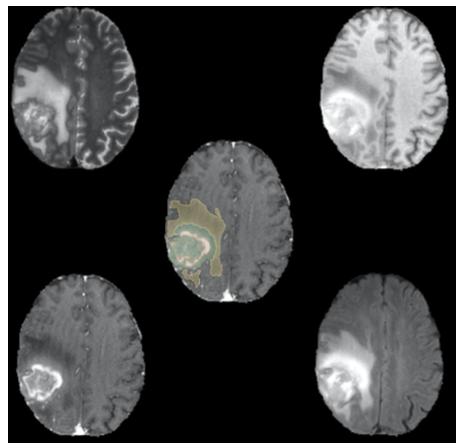

* 중앙 : t1에 mask입힌 영상, 빨간색 : ET, 초록색 : NET&NCR, 노락색 : ED
* 왼쪽 위 : T2, 오른쪽 위 : T1, 왼쪽 아래 : T1Gd, 오른쪽 아래 : FLAIR

# 1. EDA

In [61]:
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm
from IPython.display import display
from scipy import ndimage

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
# train_path 외에는 이번 EDA 노트에서는 사용하지 않음.
class cfg: 
    base_path = Path('/kaggle/input/brats20-dataset-training-validation/')
    train_path = base_path/'BraTS2020_TrainingData'/'MICCAI_BraTS2020_TrainingData'
    valid_path = base_path/'BraTS2020_ValidationData'/'MICCAI_BraTS2020_ValidationData'
    train_meta_csv   = train_path/'name_mapping.csv'
    train_survival_csv   = train_path/'survival_info.csv'
    
    valid_meta_csv   = valid_path/'name_mapping.csv'
    valid_survival_csv   = valid_path/'survival_info.csv'

### 1.1 Check & Counting data
* data의 위치 확인 및 갯수 확인은 필요하다.

In [63]:
check_file = lambda x : x if x.is_file() else None
## load all dataset folder
data_dict = {'Brats20ID':[], 'flair':[], 't1':[], 't1ce':[], 't2':[], 'mask':[]}
folder_pathes = natsorted(list(cfg.train_path.glob('*')))

data_dicts = []
for sample_path in tqdm(folder_pathes): 
    ## get images and labels
    flair_path = sample_path/str(sample_path.name+'_flair.nii')
    t1_path     = sample_path/str(sample_path.name+'_t1.nii')
    t1ce_path   = sample_path/str(sample_path.name+'_t1ce.nii')
    t2_path     = sample_path/str(sample_path.name+'_t2.nii')
    mask_path   = sample_path/str(sample_path.name+'_seg.nii')
    
    data_dict['Brats20ID'].append(sample_path.name)
    data_dict['flair'].append(check_file(flair_path))
    data_dict['t1'].append(check_file(t1_path))
    data_dict['t1ce'].append(check_file(t1ce_path))
    data_dict['t2'].append(check_file(t2_path))
    data_dict['mask'].append(check_file(mask_path))

df = pd.DataFrame(data_dict)

  0%|          | 0/371 [00:00<?, ?it/s]

In [64]:
df

,Brats20ID,flair,t1,t1ce,t2,mask
0,BraTS20_Training_001,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
1,BraTS20_Training_002,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
2,BraTS20_Training_003,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
3,BraTS20_Training_004,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
4,BraTS20_Training_005,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
...,...,...,...,...,...,...
366,BraTS20_Training_367,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
367,BraTS20_Training_368,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
368,BraTS20_Training_369,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
369,name_mapping.csv,None,None,None,None,None


In [65]:
df.isna().sum()

Brats20ID    0
flair        2
t1           2
t1ce         2
t2           2
mask         3
dtype: int64

In [66]:
display(df.count())

Brats20ID    371
flair        369
t1           369
t1ce         369
t2           369
mask         368
dtype: int64

In [67]:
train = df.dropna().reset_index(drop=True)
display(train.count())

Brats20ID    368
flair        368
t1           368
t1ce         368
t2           368
mask         368
dtype: int64

In [68]:
# check NAN value
df.isna().sum() # 각 열에 존재하는 결측값(누락된 데이터)의 개수를 확인
display(df.count()) # 각 열에서 NaN이 아닌 값(유효한 값)의 개수
train = df.dropna().reset_index(drop=True) # df.dropna() NaN이 포함된 행을 제거하고, 결측값이 없는 행만 유지. .reset_index(drop=True) 삭제된 행들로 인해 생긴 인덱스의 공백을 리셋하고, 새로운 연속적인 인덱스를 부여.
# drop=True를 사용하여 기존 인덱스를 제거하고 새롭게 인덱스를 재구성.
display(train.count()) # 결측값이 제거된 train 데이터프레임에서 각 열의 유효한 값 개수를 다시 출력. df.count()와 비교하면, 얼마나 많은 행이 제거되었는지 확인 가능.

Brats20ID    371
flair        369
t1           369
t1ce         369
t2           369
mask         368
dtype: int64

Brats20ID    368
flair        368
t1           368
t1ce         368
t2           368
mask         368
dtype: int64

<Axes: >

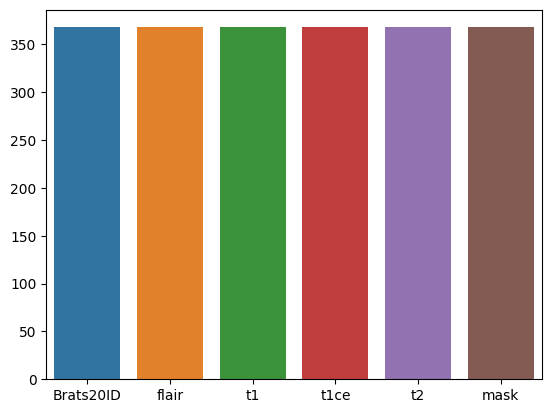

In [69]:
sns.barplot(train.count().to_frame().T)

## 1.2 get all meta data
* 모든 데이터의 meta data를 읽어봅시다.

In [70]:
train.head()

,Brats20ID,flair,t1,t1ce,t2,mask
0,BraTS20_Training_001,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
1,BraTS20_Training_002,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
2,BraTS20_Training_003,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
3,BraTS20_Training_004,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...
4,BraTS20_Training_005,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...


* 현제 Brats에서 제공해주고 있는 Survival csv도 함께 읽어와서 지금 데이터와 병합을 해봅니다. 

In [71]:
train_survival_df = pd.read_csv(cfg.train_survival_csv)
merge_df = train.merge(train_survival_df, how='inner', on='Brats20ID')

In [72]:
train_survival_df # 활용하지 않음.

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR
...,...,...,...,...
231,BraTS20_Training_363,57.000,62,GTR
232,BraTS20_Training_366,72.000,633,GTR
233,BraTS20_Training_367,60.000,437,STR
234,BraTS20_Training_368,49.000,442,GTR


* nifity파일을 읽어오기 위해서는 다양한 tool이 있습니다. 
* 대표적으로 Simple ITK & nibabel이 있는데요 
* 이 두개의 라이브러리를 비교해보고 또한 meta data추출까지 진행을 해보록 하겠습니다.

In [73]:
import SimpleITK as sitk
import nibabel as nib

In [74]:
all_data_path = merge_df[['flair','t1','t1ce','t2']].values # dataframe load하여 동일한 이미지 추출

img = sitk.ReadImage(all_data_path[0][0]) # flair이미지 추가 후 속도 측정
%time a = sitk.GetArrayFromImage(img)
img = nib.load(all_data_path[0][0])
%time a = img.get_fdata()

CPU times: user 5.2 ms, sys: 46 µs, total: 5.25 ms
Wall time: 5.33 ms
CPU times: user 8.61 ms, sys: 36.4 ms, total: 45 ms
Wall time: 46.8 ms


* Sitk가 빠른것을 확인이 되었으나 nifity와 itk두개의 라이브러리에서 필수 meta data를 추출해봅시다.

In [75]:
# https://bo-10000.tistory.com/27

In [76]:
## nibabel version 
sample_img = nib.load(all_data_path[0][0])

name = all_data_path[0][0].name
sample_header = sample_img.header
img = sample_img.get_fdata()
print(f'file name : {name}')
print(f'image shape : {sample_header.get_data_shape()}')
print(f'Pixel spacing : {sample_header.get_zooms()}')
print(f'Data type : {sample_header.get_data_dtype()}')
print(f'Min, Max value : {np.min(img), np.max(img)}')
print('-------------------------------------------------')
# # ## itk version 
sample_img = sitk.ReadImage(all_data_path[0][0])
img = sitk.GetArrayFromImage(sample_img)
print(f'image shape : {sample_img.GetSize()}')
print(f'Pixel spacing : {sample_img.GetSpacing()}')
print(f'Data type : {sample_img.GetPixelIDTypeAsString()}')
print(f'Min, Max value :{np.min(img), np.max(img)}')

file name : BraTS20_Training_001_flair.nii
image shape : (240, 240, 155)
Pixel spacing : (1.0, 1.0, 1.0)
Data type : int16
Min, Max value : (0.0, 625.0)
-------------------------------------------------
image shape : (240, 240, 155)
Pixel spacing : (1.0, 1.0, 1.0)
Data type : 16-bit signed integer
Min, Max value :(0, 625)


In [77]:
all_data_path[0][0]

PosixPath('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')

In [78]:
def extract_meta_data(sample_path, use_itk=True): 
    
    if use_itk: 
        sample_img = sitk.ReadImage(sample_path)
        img = sitk.GetArrayFromImage(sample_img)
        return np.min(img), np.max(img), sample_img.GetSize(), sample_img.GetSpacing()
    else: 
        sample_img = nib.load(sample_path)
        sample_header = sample_img.header
        img = sample_img.get_fdata()
        return np.min(img), np.max(img), sample_header.get_data_shape(), sample_header.get_zooms()

print(extract_meta_data(all_data_path[0][0]))

(0, 625, (240, 240, 155), (1.0, 1.0, 1.0))


In [79]:
merge_df

,Brats20ID,flair,t1,t1ce,t2,mask,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,60.463,289,GTR
1,BraTS20_Training_002,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,52.263,616,GTR
2,BraTS20_Training_003,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,54.301,464,GTR
3,BraTS20_Training_004,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,39.068,788,GTR
4,BraTS20_Training_005,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,68.493,465,GTR
...,...,...,...,...,...,...,...,...,...
230,BraTS20_Training_363,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,57.000,62,GTR
231,BraTS20_Training_366,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,72.000,633,GTR
232,BraTS20_Training_367,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,60.000,437,STR
233,BraTS20_Training_368,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,/kaggle/input/brats20-dataset-training-validat...,49.000,442,GTR


In [80]:
len(all_data_path[0])

4

In [81]:
meta_dict = {'flair_mima':[],'flair_shape':[],'flair_space':[],
             't1_mima':[],'t1_shape':[],'t1_space':[],
             't1ce_mima':[],'t1ce_shape':[],'t1ce_space':[],
             't2_mima':[],'t2_shape':[],'t2_space':[]}
for multi_modal_path in tqdm(all_data_path): 
    flair_path, t1_path, t1ce_path, t2_path = multi_modal_path
    result = [extract_meta_data(i) for i in multi_modal_path]    
    flair_meta, t1_meta, t1ce_meta, t2_meta = result 
    
    meta_dict['flair_mima'].append([flair_meta[0],flair_meta[1]])
    meta_dict['flair_shape'].append(flair_meta[2])
    meta_dict['flair_space'].append(flair_meta[3])
    
    meta_dict['t1_mima'].append([t1_meta[0],t1_meta[1]])
    meta_dict['t1_shape'].append(t1_meta[2])
    meta_dict['t1_space'].append(t1_meta[3])
    
    meta_dict['t1ce_mima'].append([t1ce_meta[0],t1ce_meta[1]])
    meta_dict['t1ce_shape'].append(t1ce_meta[2])
    meta_dict['t1ce_space'].append(t1ce_meta[3])
    
    meta_dict['t2_mima'].append([t2_meta[0],t2_meta[1]])
    meta_dict['t2_shape'].append(t2_meta[2])
    meta_dict['t2_space'].append(t2_meta[3])

  0%|          | 0/235 [00:00<?, ?it/s]

In [82]:
meta_df = pd.DataFrame(meta_dict)

In [83]:
meta_df

,flair_mima,flair_shape,flair_space,t1_mima,t1_shape,t1_space,t1ce_mima,t1ce_shape,t1ce_space,t2_mima,t2_shape,t2_space
0,"[0, 625]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 678]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1845]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 376]","(240, 240, 155)","(1.0, 1.0, 1.0)"
1,"[0, 1091]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 757]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1633]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 690]","(240, 240, 155)","(1.0, 1.0, 1.0)"
2,"[0, 773]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 709]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1898]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 385]","(240, 240, 155)","(1.0, 1.0, 1.0)"
3,"[0, 757]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 713]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1627]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 495]","(240, 240, 155)","(1.0, 1.0, 1.0)"
4,"[0, 762]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 845]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1871]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 497]","(240, 240, 155)","(1.0, 1.0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...
230,"[0.0, 697.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 775.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 1143.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 1235.0]","(240, 240, 155)","(1.0, 1.0, 1.0)"
231,"[0.0, 455.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 632.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 1056.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 1062.0]","(240, 240, 155)","(1.0, 1.0, 1.0)"
232,"[0.0, 2452.0347]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 4669.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 9805.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 11465.0]","(240, 240, 155)","(1.0, 1.0, 1.0)"
233,"[0.0, 2039.1016]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 2186.4172]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 13977.0]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0.0, 6020.0]","(240, 240, 155)","(1.0, 1.0, 1.0)"


* Check image의 Shape이 맞는지 확인해보며 shape의 형태도 맞는지 체크해본다.

In [84]:
print(meta_df['flair_space'].unique())
print(meta_df['t1_space'].unique())
print(meta_df['t1ce_space'].unique())
print(meta_df['t2_space'].unique())

[(1.0, 1.0, 1.0)]
[(1.0, 1.0, 1.0)]
[(1.0, 1.0, 1.0)]
[(1.0, 1.0, 1.0)]


In [85]:
print(meta_df['flair_shape'].unique())
print(meta_df['t1_shape'].unique())
print(meta_df['t1ce_shape'].unique())
print(meta_df['t2_shape'].unique())

[(240, 240, 155)]
[(240, 240, 155)]
[(240, 240, 155)]
[(240, 240, 155)]


min max 값은 조금씩 차이가남 그래서 다시 구성

In [86]:
meta_df['flair_min'] = meta_df['flair_mima'].apply(lambda x : x[0])
meta_df['flair_max'] = meta_df['flair_mima'].apply(lambda x : x[1])

meta_df['t1_min'] = meta_df['t1_mima'].apply(lambda x : x[0])
meta_df['t1_max'] = meta_df['t1_mima'].apply(lambda x : x[1])

meta_df['t1ce_min'] = meta_df['t1ce_mima'].apply(lambda x : x[0])
meta_df['t1ce_max'] = meta_df['t1ce_mima'].apply(lambda x : x[1])

meta_df['t2_min'] = meta_df['t2_mima'].apply(lambda x : x[0])
meta_df['t2_max'] = meta_df['t2_mima'].apply(lambda x : x[1])

In [87]:
meta_df.head()

,flair_mima,flair_shape,flair_space,t1_mima,t1_shape,t1_space,t1ce_mima,t1ce_shape,t1ce_space,t2_mima,t2_shape,t2_space,flair_min,flair_max,t1_min,t1_max,t1ce_min,t1ce_max,t2_min,t2_max
0,"[0, 625]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 678]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1845]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 376]","(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,625.0,0.0,678.0,0.0,1845.0,0.0,376.0
1,"[0, 1091]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 757]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1633]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 690]","(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,1091.0,0.0,757.0,0.0,1633.0,0.0,690.0
2,"[0, 773]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 709]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1898]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 385]","(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,773.0,0.0,709.0,0.0,1898.0,0.0,385.0
3,"[0, 757]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 713]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1627]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 495]","(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,757.0,0.0,713.0,0.0,1627.0,0.0,495.0
4,"[0, 762]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 845]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 1871]","(240, 240, 155)","(1.0, 1.0, 1.0)","[0, 497]","(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,762.0,0.0,845.0,0.0,1871.0,0.0,497.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Count'>

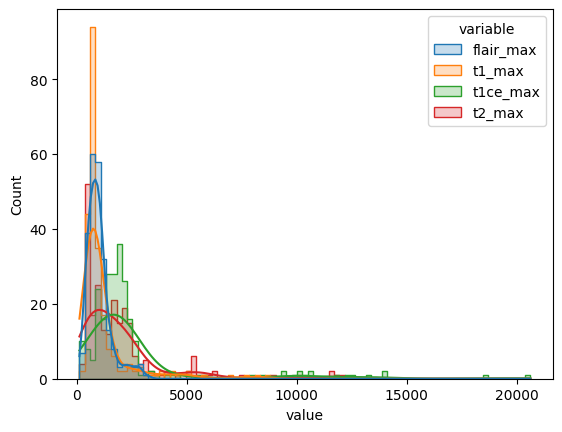

In [88]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_max','t1_max','t1ce_max','t2_max'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='value', ylabel='Density'>

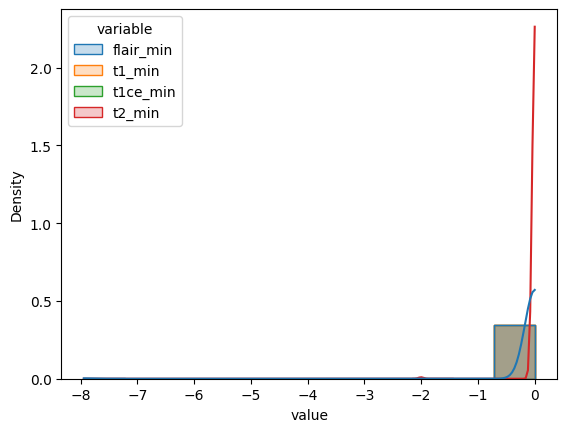

In [89]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_min','t1_min','t1ce_min','t2_min'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step", stat="density")

## 1.3 Mask annotation check 
* Check all mask has labels

In [90]:
unique_values_per_mask = {
    int(str(path).split('_')[-2] if str(path).split('_')[-2] != '1998.09.19' else '355'): np.unique(
        np.asanyarray(nib.load(str(path)).dataobj)
    ) for path in tqdm(merge_df['mask'].to_list())
}

number_of_incomplete_masks = sum(
    [1 for _, v in unique_values_per_mask.items() if set(v) != set([0,1,2,3])]
)
print(
    f'Number of complete masks: {number_of_incomplete_masks} ({number_of_incomplete_masks / len(unique_values_per_mask) * 100:.2f}%)')

  0%|          | 0/235 [00:00<?, ?it/s]

Number of complete masks: 235 (100.00%)


## 1.3 Image & mask visulization
* 다른 Notebook에서는 어떻게 image를 visulization을 했는지도 살펴보며 실습을 해보도록 하겠습니다.  

In [91]:
## reference : https://www.kaggle.com/code/mariuszwisniewski/brats2020-eda-and-data-visualization/notebook
from matplotlib import animation, cm, colors, rc
import matplotlib.patches as mpatches

DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'mask']
MASK_LABELS = ['Non-Enhancing Tumor Core',
               'Peritumoral Edema', 'GD-Enhancing Tumor']
MASK_VALUES = [0, 1, 2, 4]
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1, ki],
                       colors_rgba[i, ki]) for i in range(N+1)]
    return colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


rc('animation', html='jshtml')


def create_parallel_animation(volumes, case, show_mask=False, alpha=0.6):
    """Create animation of multiple volumes"""
    # transpose volume from (x, y, z) to (z, x, y)
    volumes = np.array([np.transpose(volume, (2, 0, 1)) for volume in volumes])
    fig = plt.figure(figsize=(12, 13))
    fig.tight_layout()
    plt.axis('off')
    plt.suptitle(f'Patient ID: {case}', fontsize=16, fontweight='bold')
    
    if show_mask: ## mask에 Color를 넣어준다. 
        custom_cmap = cmap_discretize(cm.jet, int(np.max(volumes[-1])) + 1)
        normalize = colors.Normalize(vmin=np.min(
            volumes[-1]), vmax=np.max(volumes[-1]))

    axes = []
    for idx, data_type in enumerate(DATA_TYPES[:-1]): # image에 넣을 figure를 만들어준다. 
        ax = fig.add_subplot(2, len(DATA_TYPES[:-1]) // 2, idx + 1)
        ax.set_title(data_type.upper(), weight='bold')
        axes.append(ax)

    images = []
    for i, slices in enumerate(zip(*volumes[:-1])): # 한장씩 loop를 돌면서 image를 쌓아준다. 
        aux_imgs = []
        for idx, s in enumerate(slices):
            im = axes[idx].imshow(s, animated=True, cmap='bone')
            aux_imgs.append(im)
            if show_mask:
                im2 = axes[idx].imshow(np.ma.masked_where(volumes[-1][i] == 0, volumes[-1][i]),
                                       animated=True, cmap=custom_cmap, alpha=alpha, interpolation='none')
                aux_imgs.append(im2)
        images.append(aux_imgs)

    if show_mask:
        print(np.unique(volumes[-1])[1:])
        patches = [mpatches.Patch(color=custom_cmap(normalize(col_val)),
                                  label=f'{MASK_LABELS[l_idx]}') for l_idx, col_val in enumerate(np.unique(volumes[-1])[1:])]
        plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(0.4, -0.1), borderaxespad=0.4,
                   title='Mask Labels', title_fontsize=18, edgecolor='black', facecolor='#c5c6c7')

    ani = animation.ArtistAnimation(
        fig, images, interval=5000 // len(images), blit=False, repeat_delay=1000
    )
    plt.close()
    return ani

In [ ]:
# 해당 코드 실행시 Kaggle 커널이 죽어버림 ( gif 파일로 확인 가능 )

volumes = [nib.load(volume_path).get_fdata() for volume_path in merge_df[DATA_TYPES].loc[0].to_list()]
volumes = [ndimage.rotate(volume, -90, axes=(0,1), reshape=False, order=1) for volume in volumes]

create_parallel_animation(volumes, case='1', show_mask=False)

In [ ]:
create_parallel_animation(volumes, case='1', show_mask=True)


## 

## 1.4 Image & mask visulization

In [116]:
from monai.data import DataLoader, decollate_batch, Dataset
from scipy import ndimage
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Compose,
    NormalizeIntensityd
)
from monai.visualize.utils import (
    blend_images,## label과 Image를 합친 영상
    matshow3d ## 3d image의 visulization 
)

In [117]:
data_dicts = []
for images_path, mask_path in zip(merge_df[['flair','t1','t1ce','t2']].values, merge_df['mask'].values):
    data_dicts.append({
            'image':images_path,
            'label':[mask_path]}
            )

In [118]:
data_dicts[0]["image"]

array([PosixPath('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'),
       PosixPath('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'),
       PosixPath('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'),
       PosixPath('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii')],
      dtype=object)

In [119]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])

In [120]:
train_dataset = Dataset(data_dicts, transform=train_transform)

image shape: torch.Size([4, 240, 240, 155])
label shape: torch.Size([240, 240, 155])
pixel spacing: tensor([1., 1., 1.], dtype=torch.float64)


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


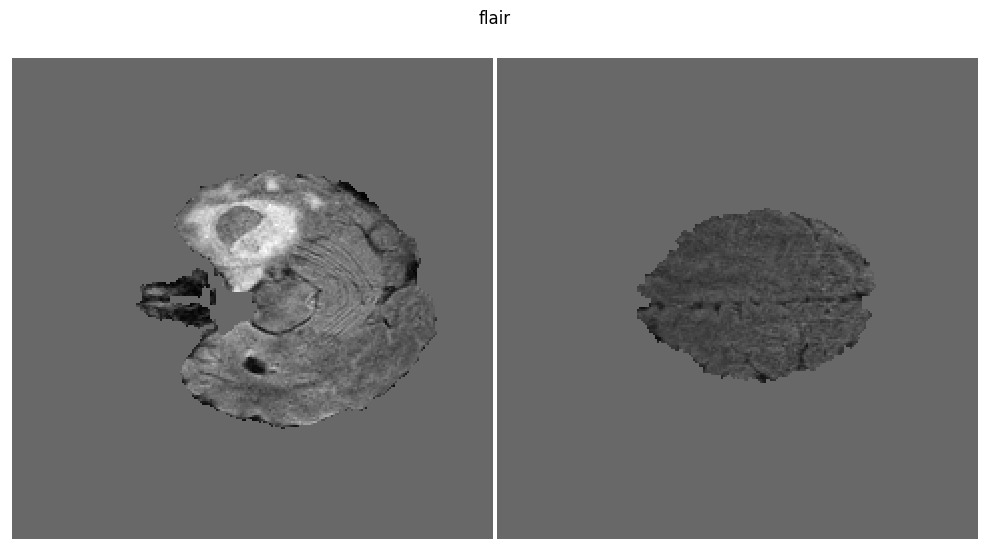

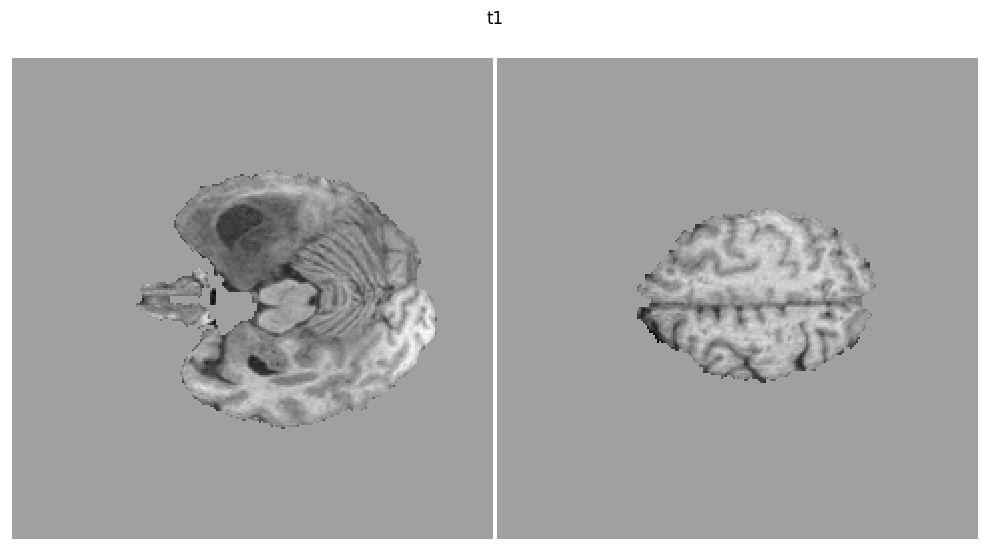

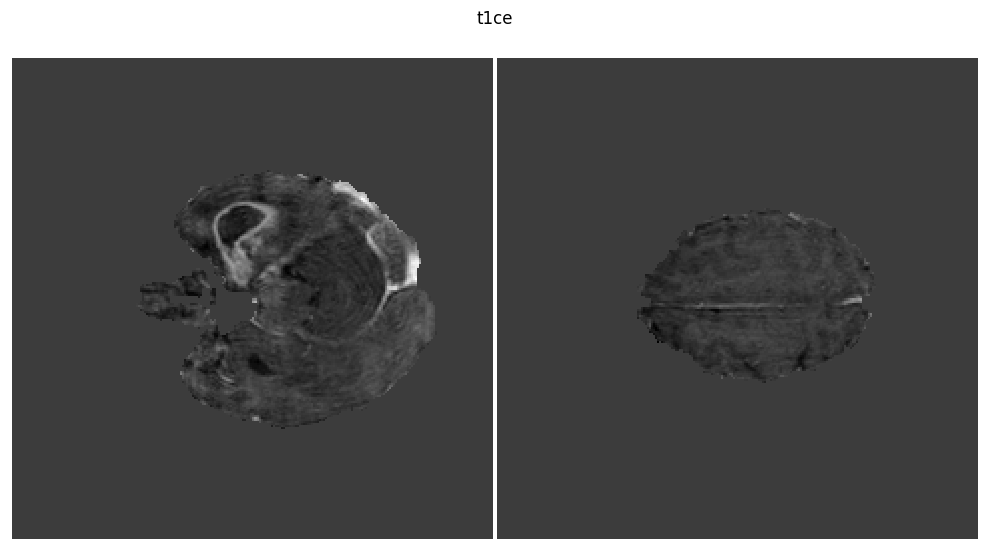

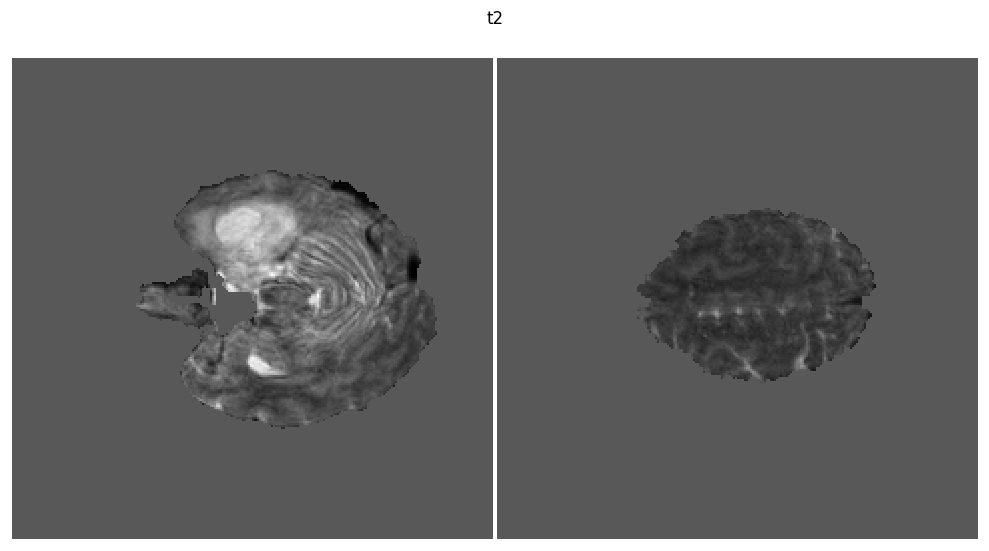

In [121]:
print(f"image shape: {train_dataset[0]['image'].shape}")
print(f"label shape: {train_dataset[0]['label'].shape}")
print(f"pixel spacing: {train_dataset[0]['image'].pixdim}")
for img, title in zip(train_dataset[0]["image"], ['flair','t1','t1ce','t2']): 
    _ = matshow3d(
    volume=img[...,50::70],
    fig=None,
    title=title,
    frame_dim=-1,
    show=True,
    cmap="gray",)

In [122]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])

In [123]:
(train_dataset[0]["label"][None]==1).max()

metatensor(True)

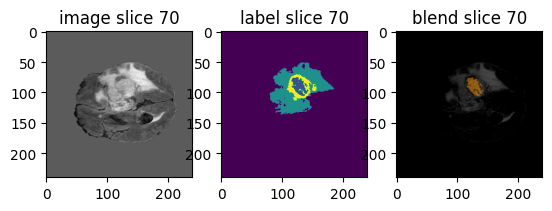

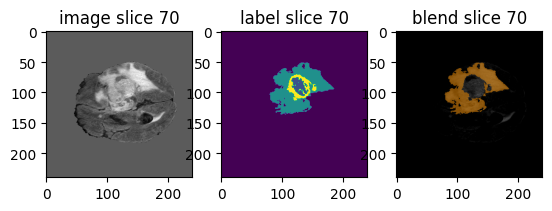

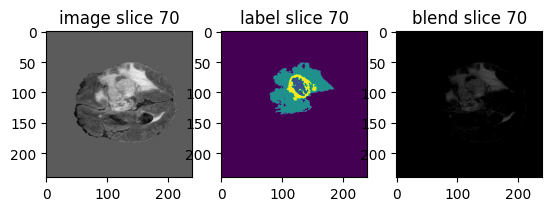

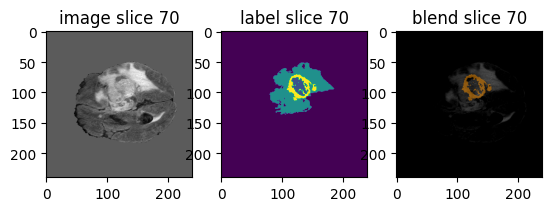

In [124]:
import matplotlib.pyplot as plt
import torch
for i in range(4): 
    if i != 4: 
        norm_img = train_dataset[0]["image"][[0]]/train_dataset[0]["image"].max()
        norm_lab = (train_dataset[0]["label"][None]==(i+1))*0.1
        ret = blend_images(image=norm_img, label=norm_lab, alpha=0.5, cmap="hsv", rescale_arrays=False)
        fig,axs = plt.subplots(1,3)
        slice_index = 70 
        axs[0].set_title(f"image slice {slice_index}")
        axs[0].imshow(train_dataset[0]["image"][0, :, :, slice_index], cmap="gray")
        axs[1].set_title(f"label slice {slice_index}")
        axs[1].imshow(train_dataset[0]["label"][:, :, slice_index])
        axs[2].set_title(f"blend slice {slice_index}")
        axs[2].imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))